# **Colon-rectal histology images classification:** A **DEEP** investigation for **LEARNING**
Mariachiara Manoccio, Marta Calasso,  Giovanni Tripicchio



In questo progetto viene mostrato un metodo di classificazione multiclasse di un dataset open-source di immagini istologiche dell'apparato colon-retto.


###**Download e import delle librerie**

In [ ]:
pip install tensorflow

In [ ]:
pip install -q tfds-nightly tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 8.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from google.colab import drive
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from tensorflow.keras.callbacks import EarlyStopping

Setting dell'unità per saving e download modelli in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_model_path = "/content/drive/MyDrive/Progetto_Deep/"

Mounted at /content/drive


###**Dataset**
Il set di dati è composto da 5000 immagini di dimensioni (150x150x3), che devono essere classificate in 8 labels, delle texture nell'istologia del cancro del colon-retto. Il dataset è scaricabile al sito [TFDS] (https://www.tensorflow.org/datasets/catalog/colorectal_histology). Tutti i dettagli sul dataset verranno mostrati nelle chunk successive.



In [ ]:
ds, ds_info = tfds.load('colorectal_histology', split='train', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.DU061Y_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


- **Numero  e tipo di di immagini nel dataset**

In [ ]:
print(f'dataset type {type(ds)} with {len(ds)} images')

dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'> with 5000 images


- **Subset dei dati**

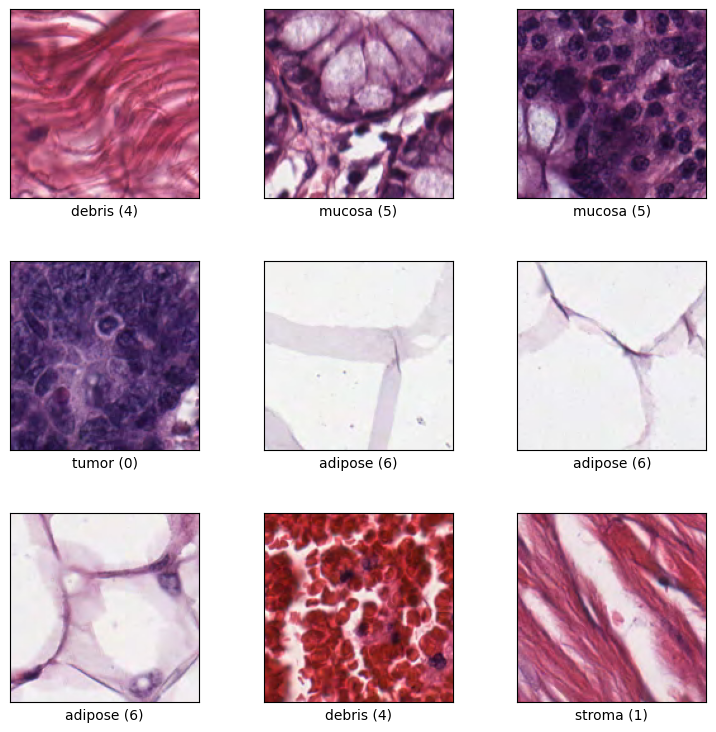

In [ ]:
fig = tfds.show_examples(ds, ds_info)

- **Numero e lista di classi presenti nel dataset**

  Di seguito si riporta il numero di immagini per categoria.
  Si ottengono 8 categorie con 625 campi. Le immagini sottostanti rappresentano un esempio di immagini per ogni categoria.

Numero di categorie: 8
Label: adipose, Count: 625
Label: complex, Count: 625
Label: debris, Count: 625
Label: empty, Count: 625
Label: lympho, Count: 625
Label: mucosa, Count: 625
Label: stroma, Count: 625
Label: tumor, Count: 625


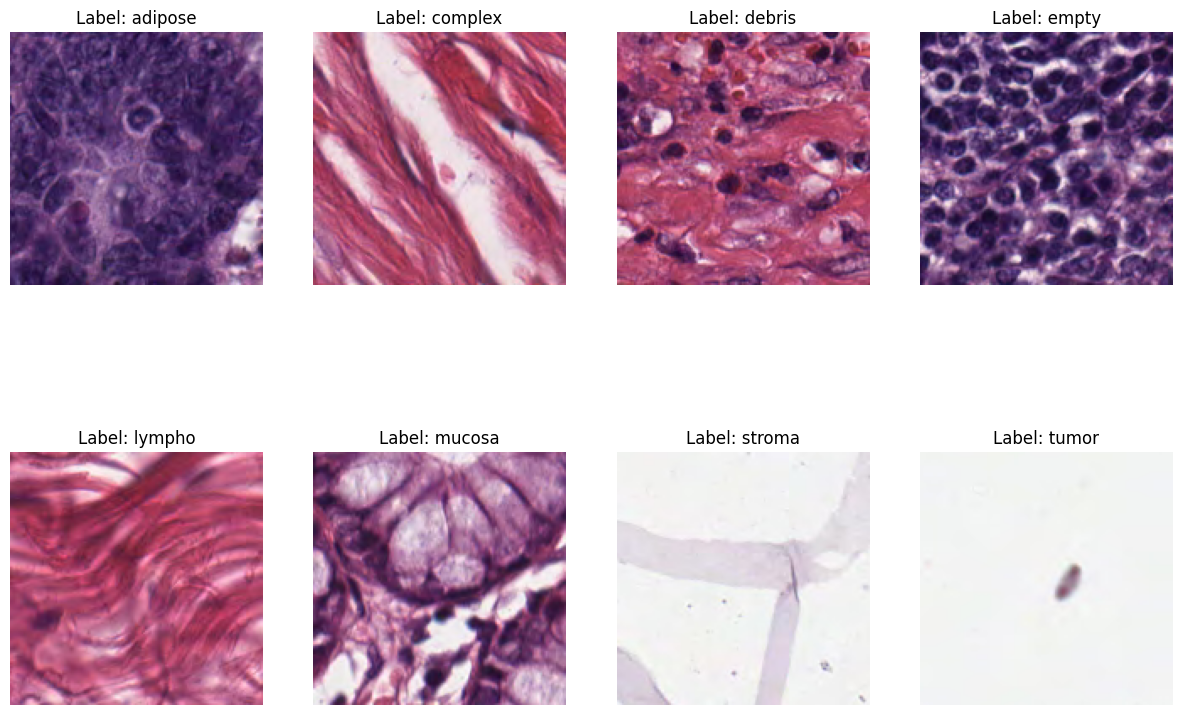

In [ ]:
# Carica il dataset colorectal_histology (si carica per evitare conflitti)
dsimg, dsimg_info = tfds.load('colorectal_histology', split='train', with_info=True)

###Count classi
num_classes=dsimg_info.features['label'].num_classes
print("Numero di categorie:", num_classes)

### Count numero di elementi per classe
label_names = np.unique(dsimg_info.features['label'].names)

label_counts = {label: 0 for label in label_names} #init dict per count occorrenze

# Conta il numero di elementi per ciascuna label
for example in dsimg:
    label = example['label'].numpy()
    label_name = label_names[label]
    label_counts[label_name] += 1

# Stampa i risultati
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

labels = np.unique(ds_info.features['label'].names)
plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    # Seleziona casualmente un'immagine per questa label
    examples = dsimg.filter(lambda x: x['label'] == i).take(1)
    for example in examples:
        image = example['image']
        plt.subplot(2, 4, i + 1)
        plt.imshow(image.numpy())
        plt.title(f'Label: {label}')
        plt.axis('off')

plt.show()

###**Data Preprocessing**

Si definisce una funzione per *normalizzare* le immagini riscalando i valori dei pixel (compresi tra 0 e 255) in un range di valori [0,1].

In [ ]:
def standardize_img(image, label):
  normalized_image = tf.cast(image, tf.float32) # Converte l'immagine in tipo float32
  normalized_image = normalized_image / 255 # Normalizza i valori dei pixel tra 0 e 1
  normalized_label = tf.one_hot(label,8) # Converte le labels in formato one-hot
  return normalized_image, normalized_label

Si applica la funzione standardize_img a ciascun elemento del dataset che standardizza le immagini convertendole in formato float32 e normalizzandole affinché abbiano media 0 e deviazione standard pari a 1. La trasformazione avviene in parallelo (attraverso l' esecuzione della funzione map), con TensorFlow che determina automaticamente il numero ottimale di chiamate parallele usando il paramero AUTOTUNE.

In [ ]:
ds = ds.map(standardize_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)

###**Dataset splitting**

Successivamente si selezionano i primi 1000 campi come dati di validation, i secondi 1000 campi per il test e i restanti per il train.

Training (60%), test (20%) and validation (20%).

In [ ]:
valid_data=ds.take(1000)
test_data=ds.skip(1000).take(1000)
train_data=ds.skip(2000).take(3000)

**Configurazione del dataset per il training.**

 Si imposta la dimensione del batch pari a 64, che è è il numero di campioni di dati elaborati insieme in una singola iterazione durante l'addestramento di un modello di deep learning.

In [ ]:
batch_size=64
valid_data= valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

Stampa delle dimensioni (larghezza e altezza) delle immagini, numero di *canali* (sono 3 poichè le immagini sono RGB) e batch size.

In [ ]:
for image_batch, labels_batch in train_data.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 150, 150, 3)
(64, 8)


Valori massimi e minimi dei pixel delle immagini riscalate

In [ ]:
for image_batch, labels_batch in train_data:
  print('Min value: ', np.min(image_batch))
  print('Max value: ', np.max(image_batch))
  break

Min value:  0.0
Max value:  1.0


# **Modelling**

#**Model_1**
Per costruire un modello di rete neurale per il dataset in esame si può utilizzare una combinazione di diversi parametri come ad esempio il numero di layer, le epoche, o le funzioni di attivazione, in cui l'architettura della rete neurale applicata è del tipo CNN (convolutional).
Si effettua una prima prova con con un modello contenente 3 blocchi di convoluzione, particolarmente efficaci per l' elaborazione di immagini, o altri tipi di dati spazialmente strutturati.

La convoluzione nelle reti neurali convoluzionali consiste nel passaggio di un filtro (kernel) su un'immagine per estrarre caratteristiche locali rilevanti, come bordi, texture o altre strutture. Questa operazione riduce la dimensione dei dati mantenendo le informazioni essenziali, migliorando l'efficienza e la capacità del modello di riconoscere schemi complessi.

Le combinazioni dei livelli convoluzionali e di pooling riducono progressivamente le dimensioni spaziali dell'immagine mentre aumentano la profondità (numero di filtri), permettendo al modello di imparare caratteristiche complesse.

L'elemento di base di una rete neurale è il layer. I layer estraggono rappresentazioni dai dati che vengono loro forniti. Viene impostato il metodo Sequential, che consente di costruire un modello definendo una sequenza di layer.

Layer1. Il primo layer contribuisce a riformattare i dati, infatti si inserisce la dimensione delle immagini accettabili nel modello (150x150x3).

Layer2. Primo Convolutional Layer: applica 16 filtri convoluzionali di dimensione 5x5 utilizzando la tecnica di padding (che consiste nell'aggiungere pixel, tipicamente con valore zero ai bordi dell'immagine o della matrice di input) di tipo 'same', che preserva la dimensione spaziale dell'input. La funzione di attivazione impiegata è la ReLU, comunemente usata negli hidden layers per introdurre non linearità.

Layer3. Si applica il pooling massimo su finestre di dimensioni 2x2 per ridurre la dimensione spaziale delle rappresentazioni mantenendo però le informazioni rilevanti.

Layer4. Secondo layer di convoluzione. Applica 32 filtri convoluzionali di dimensione 5x5. Anche questo utilizza padding 'same' e la funzione di attivazione ReLU.

I successivi layers hanno le stesse caratteristiche alternate tra layer 1 e layer 3, cambiando il numero di filtri applicati. Un hidden layer comprende anche una funzione analoga al pooling massimo, che applica il pooling medio.

.

.

.

La parte finale del modello consiste in livelli completamente connessi che effettuano la classificazione basandosi sulle caratteristiche estratte dai convolutional layers.

Layer8. Trasforma l'output tridimensionale delle convolutional layers in un vettore unidimensionale, preparandolo per il livello denso.

Layer9-Layer11. Layer Densi: Livelli completamente connessi aventi rispettivamente 64, 32 e 16 neuroni con funzione di attivazione ReLU.

Layer12. Applica la tecnica del dropout con una probabilità del 50% per prevenire l'overfitting disattivando casualmente neuroni durante il 50% dei neuroni durante l'addestramento, riducendo la dipendenza del modello su specifici path nei dati.

Layer13. Livello di output con numero di neuroni pari al numero delle classi (8). Utilizza la funzione di attivazione softmax per produrre una distribuzione di probabilità per le classi di output.

In [ ]:
#definizione modello
model = Sequential([
  layers.Input(shape=(150, 150, 3)),
  layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

Il seguente summary fornisce una panoramica dettagliata dell'architettura del modello, inclusi i tipi di layer, le dimensioni degli output e il numero totale di parametri addestrabili.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 average_pooling2d (Average  (None, 37, 37, 64)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0

Questo codice esegue il train del modello utilizzando l'ottimizzatore Adam utilizzato comunemente per la capacità di adattare i tassi di apprendimento per ciascun peso della rete, con una loss function di "categorical_crossentropy" (molto usata per le classificazioni multiclasse) e come metriche di valutazione, incluse l'accuratezza e l'accuratezza "categorical top-k", utile quando si trattano i problemi multiclasse. La metrica top-k misura l'accuratezza di un modello nel contesto in cui si considerano i primi k risultati predetti dal modello stesso, valutando se la risposta corretta è inclusa tra le prime k previsioni fatte dal modello.

Si effettua il training del modello sui dati di train e si osservano le performances utilizzando i dati di validation. Viene specificato di eseguire l'addestramento per 30 epoche, equivalente al numero di volte in cui l'intero set di dati viene mostrato alla rete durante l'addestramento.
Durante il training il modello cerca di ridurre la loss function sul set di addestramento. Le metriche specificate nella compilazione vengono calcolate sia sul set di train che su quello di validation ad ogni epoca per valutare le performance del modello.
Il risultato del training viene memorizzato nell'oggetto history, che contiene informazioni come le loss e le metriche per ogni epoca. Questo oggetto può essere utilizzato successivamente per tracciare le curve di apprendimento e valutarne le performances.

In [ ]:
model.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ['accuracy', 'top_k_categorical_accuracy'])
history = model.fit(train_data, validation_data = valid_data,
                    epochs = 30)

Epoch 1/30
47/47 [==============================] - 325s 7s/step - loss: 2.0046 - accuracy: 0.1690 - top_k_categorical_accuracy: 0.7013 - val_loss: 1.7661 - val_accuracy: 0.2470 - val_top_k_categorical_accuracy: 0.8040
Epoch 2/30
47/47 [==============================] - 302s 6s/step - loss: 1.8678 - accuracy: 0.2237 - top_k_categorical_accuracy: 0.7733 - val_loss: 1.6957 - val_accuracy: 0.2750 - val_top_k_categorical_accuracy: 0.9010
Epoch 3/30
47/47 [==============================] - 303s 6s/step - loss: 1.8082 - accuracy: 0.2463 - top_k_categorical_accuracy: 0.8083 - val_loss: 1.6044 - val_accuracy: 0.3720 - val_top_k_categorical_accuracy: 0.9530
Epoch 4/30
47/47 [==============================] - 308s 7s/step - loss: 1.6487 - accuracy: 0.3087 - top_k_categorical_accuracy: 0.8897 - val_loss: 1.4098 - val_accuracy: 0.4220 - val_top_k_categorical_accuracy: 0.9910
Epoch 5/30
47/47 [==============================] - 317s 7s/step - loss: 1.5211 - accuracy: 0.3473 - top_k_categorical_accur

Salvataggio del modello pre-trainato

In [ ]:
#model.save(save_model_path+'model_1DL.h5')


### **Evaluation Model_1**

Si creano funzioni per il plot dei grafici per confrontare accuracy e loss function per i valori ottenuti per i modelli di dataset di train e validation al variare del numero di epoche.

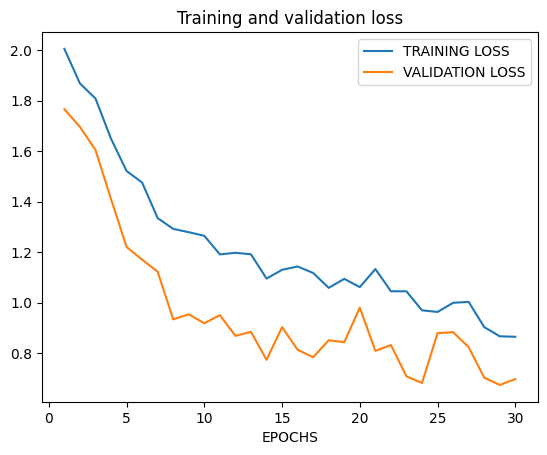

In [ ]:
def loss_graph(history):
  #Loss function graph
  history_dict = history.history
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, label = 'TRAINING LOSS')
  plt.plot(epochs, val_loss, label = 'VALIDATION LOSS')
  plt.xlabel('EPOCHS')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

loss_graph(history)

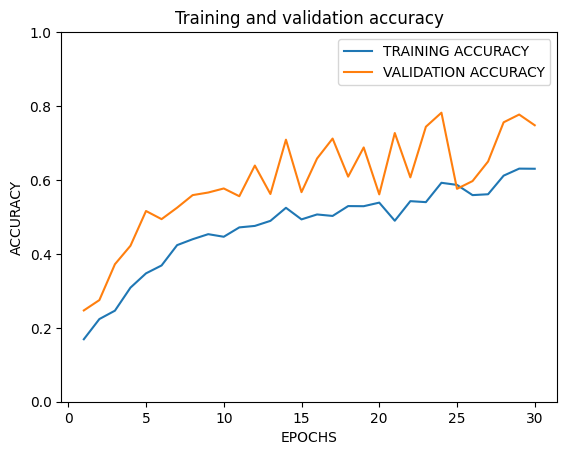

In [ ]:
def accuracy_graph(history):
  #Loss function graph
  history_dict = history.history
  acc = history_dict['accuracy']
  epochs = range(1, len(acc) + 1)
  val_acc = history_dict['val_accuracy']
  plt.plot(epochs, acc, label='TRAINING ACCURACY')
  plt.plot(epochs, val_acc, label = 'VALIDATION ACCURACY')
  plt.xlabel('EPOCHS')
  plt.ylabel('ACCURACY')
  plt.ylim(0,1)
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()


accuracy_graph(history)

Valutazione performance modello applicato al test set

In [ ]:
model.evaluate(test_data)
test_loss, test_acc, test_top_acc = model.evaluate(test_data)
print(f'Test accuracy:{test_acc * 100:.2f}%')
print(f'Test top_k_accuracy:{test_top_acc * 100:.2f}%')

16/16 [==============================] - 26s 2s/step - loss: 0.6805 - accuracy: 0.7330 - top_k_categorical_accuracy: 0.9950
Test accuracy:73.30%
Test top_k_accuracy:99.50%


##**Model_1 Discussione**
Con questo modello è stata ottenuta un'accuracy sul test di circa il 73.3% e una top-K accuracy dell 99.5%. Top-K Categorical Accuracy calcola la percentuale di record per i quali i target si trovano nelle K posizioni principali. Si nota che K è un parametro da specificare altrimenti (come in questo progetto), di default in keras il suo valore di default è 5, valore per cui la metrica raggiunge il 99% di top-k categorical accuracy. Nel modello in esame in realtà questi valori non sono attendibili. Infatti i grafici mostrano un totale disaccordo tra il dataset di validation e di train per il numero di epoche scelto, pertanto bisogna valutare altri parametri per il modello per migliorarne le metriche.

#**Model_2**

Un questa seconda sezione del modelling si prova a verificare gli effetti dell'aggiunta di tecniche di regolarizzazione per prevenire l'overfitting riumuovendo la funzione dropout e aggiungendo 2 livelli densi con la funzione di regolarizzazione L2, che utilizza la somma dei quadrati dei pesi.  Inoltre per prevenire l' overfitting si considera anche la tecnica early stopping. Questa tecnica blocca l'addestramento se non si osservano miglioramenti per un certo numero di epoche, prevenendo l' overfitting. Questo approccio migliora la generalizzazione del modello e risparmia risorse computazionali.

In [ ]:
#import modello salvato precedentemente
# source_model= load_model(save_model_path+'model_1DL.h5', compile=False)

Definizione modello

In [ ]:
model_2 = Sequential([
  layers.Input(shape=(150, 150, 3)),
  layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(num_classes, activation='softmax')
])


In [ ]:
#Summary architettura del modello utilizzato
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 average_pooling2d_1 (Avera  (None, 37, 37, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)        102464    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 18, 18, 64)       

Training Modello_2 utilizzando early stopping per fermare il numero di epoche quando le funzioni validation e test assumono valori molto vicini tra loro.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#patience=5: considera altre 5 epoche dopo la predefinita
#restore_best_weights=True: considera il modello con val_loss più bassa

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', 'top_k_categorical_accuracy'])

history_2 = model_2.fit(train_data,
                        validation_data=valid_data,
                        epochs=30,
                        callbacks=[early_stopping])

Epoch 1/30
47/47 [==============================] - 303s 6s/step - loss: 1.9643 - accuracy: 0.3213 - top_k_categorical_accuracy: 0.9123 - val_loss: 1.5864 - val_accuracy: 0.4280 - val_top_k_categorical_accuracy: 0.9800
Epoch 2/30
47/47 [==============================] - 303s 6s/step - loss: 1.4577 - accuracy: 0.5033 - top_k_categorical_accuracy: 0.9747 - val_loss: 1.7960 - val_accuracy: 0.5100 - val_top_k_categorical_accuracy: 0.9880
Epoch 3/30
47/47 [==============================] - 303s 6s/step - loss: 1.1533 - accuracy: 0.6137 - top_k_categorical_accuracy: 0.9877 - val_loss: 1.0667 - val_accuracy: 0.6530 - val_top_k_categorical_accuracy: 0.9950
Epoch 4/30
47/47 [==============================] - 316s 7s/step - loss: 1.0650 - accuracy: 0.6193 - top_k_categorical_accuracy: 0.9883 - val_loss: 0.8176 - val_accuracy: 0.7390 - val_top_k_categorical_accuracy: 0.9970
Epoch 5/30
47/47 [==============================] - 303s 6s/step - loss: 0.8167 - accuracy: 0.7327 - top_k_categorical_accur

In [ ]:
#salvataggio del modello
#model_2.save(save_model_path+'model_2DL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##**Evaluation Model_2**
In questa sezione si confrontano i grafici di accuracy e loss per i modelli calcolati per i set di train e validation e si calcolano le performance sul test per il Modello 2.

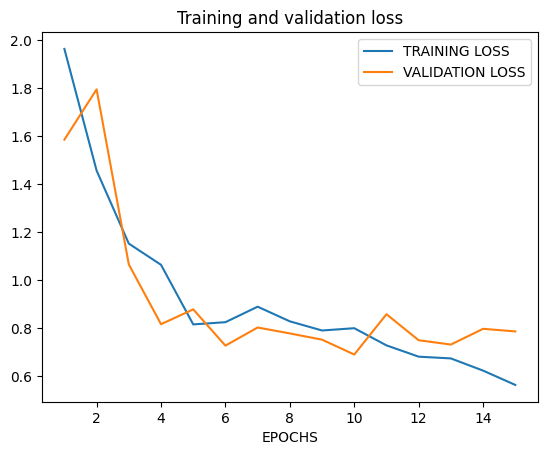

In [ ]:
loss_graph(history_2)

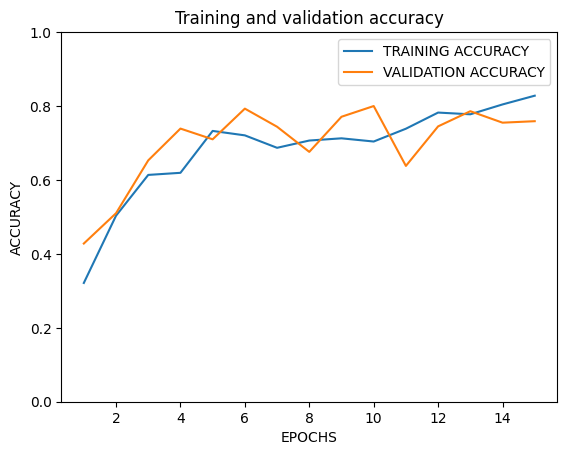

In [ ]:
accuracy_graph(history_2)

In [ ]:
#performance sul test
test_loss, test_acc, test_top_acc = model_2.evaluate(test_data)
print(f'Test accuracy:{test_acc * 100:.2f}%')
print(f'Test top_k_accuracy:{test_top_acc * 100:.2f}%')

16/16 [==============================] - 27s 2s/step - loss: 0.7133 - accuracy: 0.7760 - top_k_categorical_accuracy: 0.9990
Test accuracy:77.60%
Test top_k_accuracy:99.90%


##**Model_2 Discussione**
In questa sezione si osserva un miglioramento sull' accordo tra i dati di validation e di train rispetto al dataset precedente. Con l' early stopping il numero di epoche si ferma circa a 20. Inoltre, l'accuracy è aumentata del 5% circa, mentre la top-k categorical accuracy si trova al 99.9%.


#**Model_3**
In questa sezione si importa il Modello 2 definito precedentemente e si aggiunge un livello di data augmentation, per provare a migliorare la capacità di generalizzazione del modello.


In [ ]:
#import modello salvato precedentemente
# source_model= load_model(save_model_path+'model_1DL.h5', compile=False)

Definizione modello con data augmentation. Viene utilizzato 'Sequential' per applicare una sequenza di trasformazioni di data augmentation alle immagini in input. I layer di questo modello eseguiranno il flip, rotazione e zoom delle immagini. Queste trasformazioni avvengono ogni volta che un'immagine viene passata attraverso il layer durante l'addestramento, generando nuove variazioni delle immagini originali.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(150,
                                  150,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

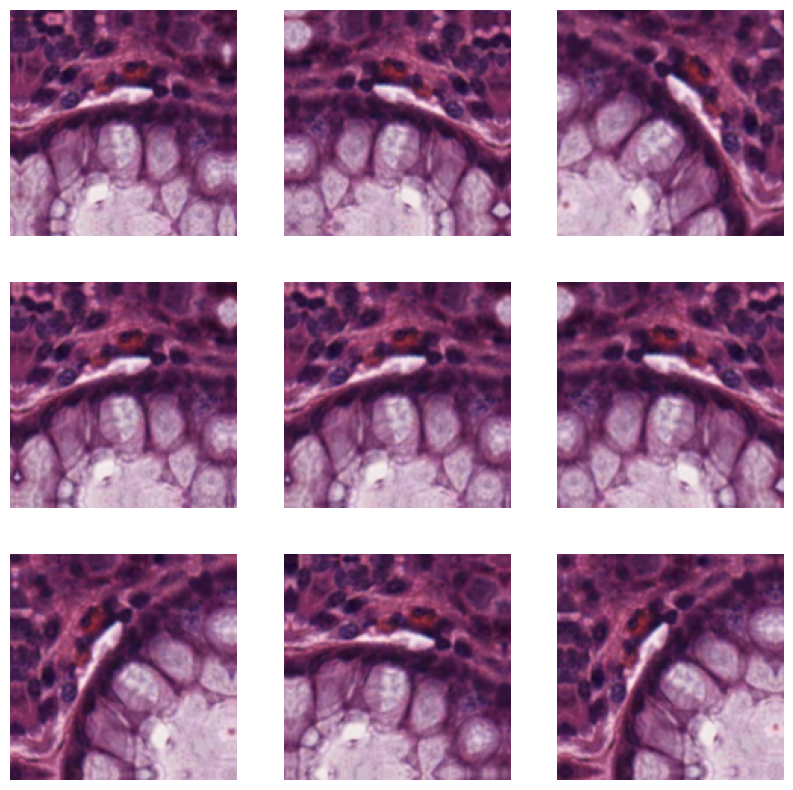

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")

 Il nuovo modello di rete neurale mostrato nella chunk successiva, avrà:
Un layer di input con una specificata dimensione delle immagini e un layer di data augmentation che applica trasformazioni casuali alle immagini. Gli altri layer sono quelli definiti nel modello addestrato precedentemente.

In [ ]:
#Definizione modello_3
model_3 = Sequential()
model_3.add(Input(shape=(150,150, 3)))
model_3.add(data_augmentation)
for layer in model_2.layers:
  layer.trainable=True
  model_3.add(layer)
print('\nDEEPER INTO THE NEW MODEL:\n')
for i,layer in enumerate(model_3.layers):
  print(f'{i} - {layer.name} - Trainable: {layer.trainable}')

#Training modello_3
model_3.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ['accuracy', 'top_k_categorical_accuracy'])
history_3= model_3.fit(train_data, validation_data = valid_data,
                    epochs = 20)


DEEPER INTO THE NEW MODEL:

0 - sequential_2 - Trainable: True
1 - conv2d_3 - Trainable: True
2 - max_pooling2d_2 - Trainable: True
3 - conv2d_4 - Trainable: True
4 - average_pooling2d_1 - Trainable: True
5 - conv2d_5 - Trainable: True
6 - max_pooling2d_3 - Trainable: True
7 - flatten_1 - Trainable: True
8 - dense_4 - Trainable: True
9 - dense_5 - Trainable: True
10 - dense_6 - Trainable: True
11 - dense_7 - Trainable: True
Epoch 1/20
47/47 [==============================] - 320s 7s/step - loss: 0.9851 - accuracy: 0.6463 - top_k_categorical_accuracy: 0.9930 - val_loss: 0.7651 - val_accuracy: 0.7660 - val_top_k_categorical_accuracy: 0.9970
Epoch 2/20
47/47 [==============================] - 315s 7s/step - loss: 0.7485 - accuracy: 0.7530 - top_k_categorical_accuracy: 0.9957 - val_loss: 0.6756 - val_accuracy: 0.7950 - val_top_k_categorical_accuracy: 0.9980
Epoch 3/20
47/47 [==============================] - 313s 7s/step - loss: 0.6854 - accuracy: 0.7810 - top_k_categorical_accuracy: 0.99

In [ ]:
#summary dell' arachitettura dei parametri del modello_3.
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 average_pooling2d_1 (Avera  (None, 37, 37, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)       

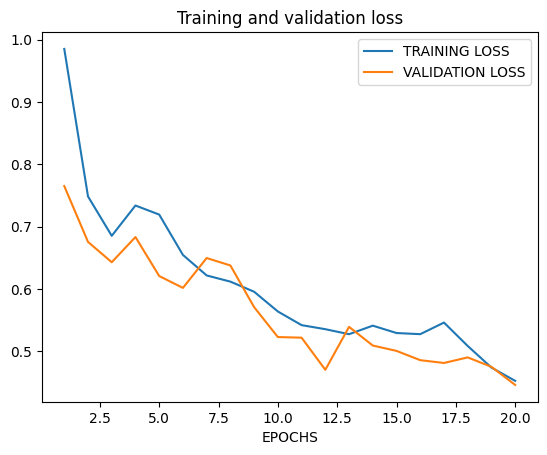

In [ ]:
loss_graph(history_3)

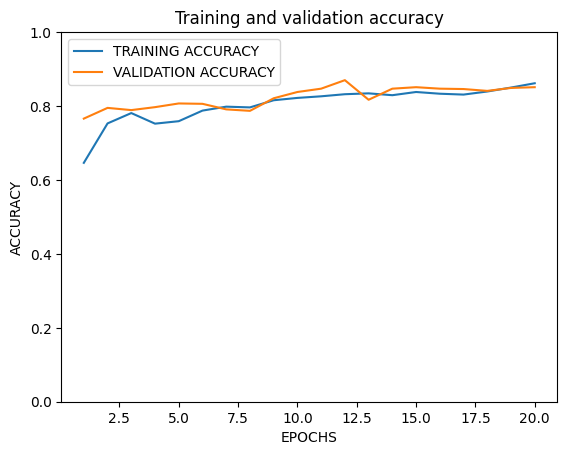

In [ ]:
accuracy_graph(history_3)

In [ ]:
#performance sul test
test_loss, test_acc, test_top_acc = model_2.evaluate(test_data)
print(f'Test accuracy:{test_acc * 100:.2f}%')
print(f'Test top_k_accuracy:{test_top_acc * 100:.2f}%')

16/16 [==============================] - 27s 2s/step - loss: 0.4424 - accuracy: 0.8680 - top_k_categorical_accuracy: 0.9990
Test accuracy:86.80%
Test top_k_accuracy:99.90%


##**Model_3 Discussione**



Con l' aggiunta del layer di data augmentation sono state osservate performance superiori rispetto alla precedente (accuracy 87%, top-k 99.9%). I grafici suggeriscono un buon accordo tra il dataset di validation e di train per il numero di epoche scelto.

#**Conclusioni**

In questo progetto sono state analizzate delle immagini istologiche dell'apparato colon-retto per affrontare un problema di classificazione multiclasse (8 classi). Nella prima parte è stata condotta un'analisi esplorativa sul dataset, evidenziandone le caratteristiche principali. Nella seconda parte è stato preprocessato il dataset (sono state eseguite operazioni di standardizzazione e split in train test e validation) e infine sono stati testati 3 modelli per individuare il miglior modello per il dataset in esame. In questa parte sono stati considerati diversi layers con diversi parametri, incluse convoluzioni con diversi kernel applicati, trattandosi di un dataset di immagini. Questa prima applicazione ha portato a un risultato inconsistente (per il numero di epoche scelto), in quanto non è stato osservato accordo tra train e validation set.
Successivamente per migliorare le prestazioni sono stati inseriti dei layer di regolarizzazione l2 ed è stata applicata la tecnica di early stopping durante l'addestramento, fermandolo a  meno di 15 epoche. Con questi metodi l' accuracy è aumentata al 77%, mentre la una top-k-categorical accuracy (settata di default a k=5) ha mostrato un risultato di 99.9%.  Nell' ultimo modello sono state effettuate operazioni di data augmentation, per provare a migliorare la capacità di generazione del modello. Il modello è stato testato su 20 epoche, e ha mostrato un buon accordo nei risultati di accuracy e loss function per validation e test, mentre le performance sono salite all' 87% per l' accuracy e costante per top_k_accuracy. Non è stato osservato overfitting per quest ultimo modello, il modello 3, che si è rivelato essere il migliore tra i modelli sviluppati.